# Segment-Averaged Speed Simulation Test

Here we test feeding LOGIOS segment-averaged drive cycle data into FASTSim, rather than the raw drive-cycle data.  

That is, given some raw 1-second granularity drive cycle data (timeseries data of both speed and gradient), produce 1-second granularity timeseries where the speed and gradient values are averaged over X-meter segments (segment length X could be 50, 100, whatever).

Then compare how the simulations for the raw and segment-averaged drive cycles compare.

Motivation: The segment-averaged drive cycles are the sort of data we'll have access too at scale. We'll assemble drive cycles from bus route shapefiles and waze averaged speed data. So it'll be useful to see how well that sort of segment-averaged drive cycle can approximate a experimentally-recordded raw drive cycle recorded with a sensor on a bus.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import namedtuple

In [2]:
from fastsim import simdrive, vehicle, cycle
import utils
utils.run_tests()

## Visualizing the segment-averaged speed and slopes for a 2-minute portion of the AB03 driving cycle

There are 5807 50-meter segments in this 290.3 km route


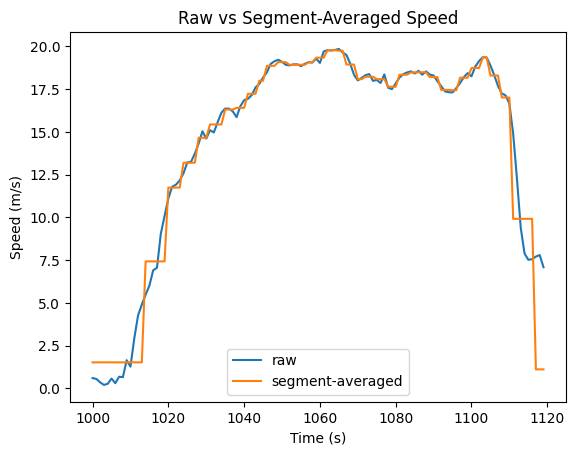

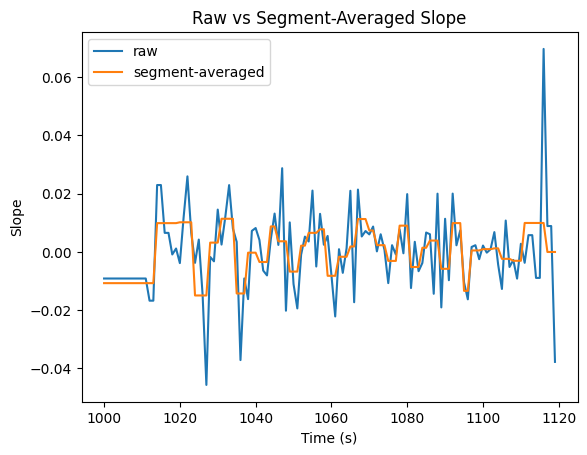

In [40]:
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
path = Path(INPUT_PATH) / 'AB03' / '0520'
cyc_df = pd.DataFrame(utils.load_drive_cycle(path))
avg_df = pd.DataFrame(utils.load_drive_cycle(path, segment_averaged=True))

time_range = range(1000, 1000 + 2*60) # 2 minutes
raw_window = cyc_df[time_range.start:time_range.stop]
avg_window = avg_df[time_range.start:time_range.stop]

plt.plot(raw_window['cycSecs'], raw_window['cycMps'], label='raw')
plt.plot(avg_window['cycSecs'], avg_window['cycMps'], label='segment-averaged')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Raw vs Segment-Averaged Speed')
plt.legend()
plt.show()

plt.plot(raw_window['cycSecs'], raw_window['cycGrade'], label='raw')
plt.plot(avg_window['cycSecs'], avg_window['cycGrade'], label='segment-averaged')
plt.xlabel('Time (s)')
plt.ylabel('Slope')
plt.title('Raw vs Segment-Averaged Slope')
plt.legend()
plt.show()

# Compare FASTSim output for Raw vs. Segment-Averaged drive cycle

In [22]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()

# Get FASTSim outputs for comparison
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
path = Path(INPUT_PATH) / 'AB03' / '0520'

fs_output = utils.run_fastsim(path, bus_jit)
fs_df = pd.DataFrame.from_dict(fs_output)

fs_avg_output = utils.run_fastsim(path, bus_jit, segment_averaged=True)
fs_avg_df = pd.DataFrame.from_dict(fs_avg_output)

There are 5807 50-meter segments in this 290.3 km route
Time to run simulation: 2.43e+00 s


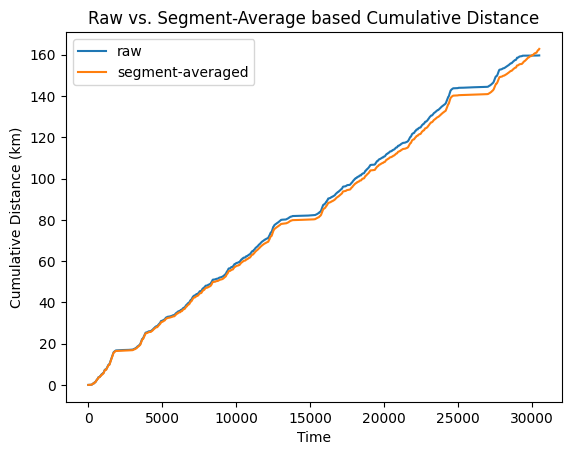

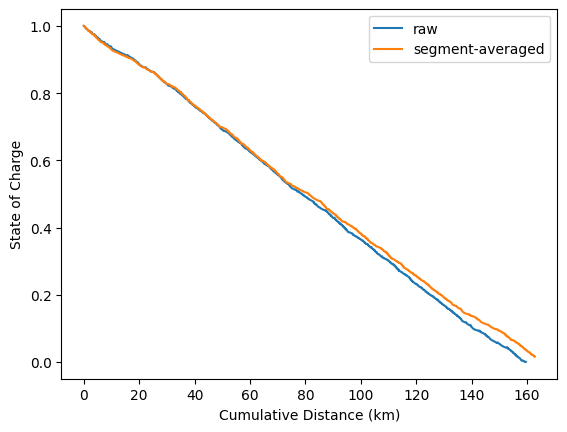

Range predicted with raw drive cycle simulation: 159.24 km
Range predicted with segment-averaged drive cycle simulation: 164.84 km
Segment-averaged drive cycle based range is 103.5% of raw


In [33]:
# Zoom in on time frame of interest
time_range = range(0, 30500)
raw_df = fs_df[time_range.start:time_range.stop]
avg_df = fs_avg_df[time_range.start:time_range.stop]

plt.plot(raw_df['time'], raw_df['cumDistKm'], label='raw')
plt.plot(avg_df['time'], avg_df['cumDistKm'], label='segment-averaged')
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.title('Raw vs. Segment-Average based Cumulative Distance')
plt.legend()
plt.show()

plt.plot(raw_df['cumDistKm'], raw_df['soc'], label='raw')
plt.plot(avg_df['cumDistKm'], avg_df['soc'], label='segment-averaged')
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('State of Charge')
plt.legend()
plt.show()

print(f"Range predicted with raw drive cycle simulation: {fs_output['rangeKm']:.02f} km")
print(f"Range predicted with segment-averaged drive cycle simulation: {fs_avg_output['rangeKm']:.02f} km")
print(f"Segment-averaged drive cycle based range is {fs_avg_output['rangeKm']*100/fs_output['rangeKm']:.01f}% of raw")

# TODO: Compare FASTSim-predicted range for raw vs segment-averaged time cycles across multiple routes

In [50]:
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
routes_and_days = {
    'AB03': {
        # Days when drive cycle data was collected for this route
        'days': ['0520', '0521', '0527', '0531'],
         
        # LOGIOS-predicted range along this route from 100% to 0% SOC.
        # Extracted from LOGIOS 'Energy Available' graph in deliverable 4 report. e.g. Fig. 4.
        'rangeKm': 221.18,
    },
    'TC08': {
        'days': ['0525'], 
        'rangeKm': 245.32,
    },
    'ATE09': {
        'days': ['0520', '0521', '0525', '0527'],
        'rangeKm': 227.11
    }
}

# Simulate all distinct (route,day) drive cycles (both raw and segment-averaged)
# and store the predicted ranges
ranges = {}
for route_name in routes_and_days.keys():
    route = routes_and_days[route_name]
    for day in route['days']:
        print(f'Processing route {route_name}, day {day}...')
        drive_cycle_path = Path(INPUT_PATH) / route_name / day
        raw_output = utils.run_fastsim(drive_cycle_path, bus_jit)
        avg_output = utils.run_fastsim(drive_cycle_path, bus_jit, segment_averaged=True)
        raw_range = raw_output['rangeKm']
        avg_range = avg_output['rangeKm']
        ranges[f'{route_name}/{day}'] = {
            'raw': raw_range,
            'segment_averaged': avg_range,
        }
ranges

Processing route AB03, day 0520...
Time to run simulation: 2.44e+00 s
There are 5807 50-meter segments in this 290.3 km route
Time to run simulation: 2.30e+00 s
Processing route AB03, day 0521...
Time to run simulation: 2.79e+00 s
There are 6299 50-meter segments in this 314.9 km route
Time to run simulation: 2.69e+00 s
Processing route AB03, day 0527...
Time to run simulation: 2.52e+00 s
There are 6236 50-meter segments in this 311.8 km route
Time to run simulation: 2.49e+00 s
Processing route AB03, day 0531...
Time to run simulation: 3.78e+00 s
There are 6995 50-meter segments in this 349.7 km route
Time to run simulation: 3.99e+00 s
Processing route TC08, day 0525...
Time to run simulation: 2.74e+00 s
There are 6062 50-meter segments in this 303.1 km route
Time to run simulation: 2.66e+00 s
Processing route ATE09, day 0520...
Time to run simulation: 2.62e+00 s
There are 5595 50-meter segments in this 279.7 km route
Time to run simulation: 2.60e+00 s
Processing route ATE09, day 0521.

{'AB03/0520': {'raw': 159.2354273058823, 'segment_averaged': 164.836065518673},
 'AB03/0521': {'raw': 168.1752807663006,
  'segment_averaged': 174.0623798006974},
 'AB03/0527': {'raw': 163.67224486279449,
  'segment_averaged': 168.11054608395028},
 'AB03/0531': {'raw': 181.31295624588725,
  'segment_averaged': 186.0563403237313},
 'TC08/0525': {'raw': 175.87274880947072,
  'segment_averaged': 176.92195482220188},
 'ATE09/0520': {'raw': 164.4043108854091,
  'segment_averaged': 176.82395991223038},
 'ATE09/0521': {'raw': 166.63495997045086,
  'segment_averaged': 182.45789912059755},
 'ATE09/0525': {'raw': 162.932761244436,
  'segment_averaged': 168.29814697944704},
 'ATE09/0527': {'raw': 169.17754871935017,
  'segment_averaged': 178.76655538433926}}

AB03/0520
AB03/0521
AB03/0527
AB03/0531
TC08/0525
ATE09/0520
ATE09/0521
ATE09/0525
ATE09/0527


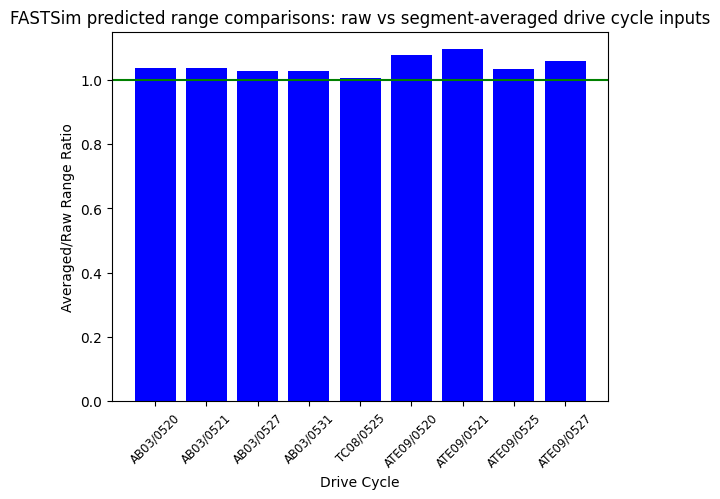

On average, of the 9 simulated drive cycles, FASTSim's segment-averaged-input predicted range is 104.3% of raw-input predicted


In [58]:
route_names = []
range_ratios = []
for route_name, range_results in ranges.items():
    print(route_name)
    range_ratio = range_results['segment_averaged'] / range_results['raw']
    route_names.append(route_name)
    range_ratios.append(range_ratio)
    
plt.bar(route_names, height=range_ratios, color='blue')
plt.title('FASTSim predicted range comparisons: raw vs segment-averaged drive cycle inputs')
plt.axhline(1.0, color='green')
plt.xlabel('Drive Cycle')
plt.ylabel('Averaged/Raw Range Ratio')
plt.xticks(rotation=45, fontsize='small')
plt.show()

print(f'On average, of the {len(ranges)} simulated drive cycles, FASTSim\'s segment-averaged-input predicted range is {np.average(range_ratios)*100:.01f}% of raw-input predicted range')

We see the two forms of drive cycle input produce very similar simulated driving range (distance travelled before using up all the energy in the battery).